### Load the neural network

In [1]:
import torch
from torch import nn

In [2]:
max_gen1 = 95  # Maximum generation capacity for Gen1
max_gen2 = 95  # Maximum generation capacity for Gen2
min_gen1 = 70  # Minimum generation capacity for Gen1
min_gen2 = 70  # Minimum generation capacity for Gen2

In [3]:
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        # Define only the layers that will learn weights
        self.layer1 = nn.Linear(3, 10)  # 3 input features, 10 hidden units
        self.relu = nn.ReLU()
        self.layer2 = nn.Linear(10, 2)  # Only 2 outputs will have learned parameters

    def forward(self, x):
        # Pass input through the learning layers
        x = self.layer1(x)
        x = self.relu(x)
        x = self.layer2(x)

        output = x

        # # Prepare the output tensor with additional slots for manual outputs
        # # Assuming x.shape[0] is the batch size
        # output = torch.zeros(x.shape[0], 6, device=x.device)
        # output[:, 0:2] = x  # Fill learned outputs

        # # Manually compute the additional outputs
        # output[:, 2] = max_gen1 - output[:, 0]  # Difference between max possible generation and actual Gen1
        # output[:, 3] = output[:, 0] - min_gen1 # Difference between min possible generation and actual Gen1
        # output[:, 4] = max_gen2 - output[:, 1]  # Difference between max possible generation and actual Gen2
        # output[:, 5] = output[:, 1] - min_gen2 # Difference between min possible generation and actual Gen2

        return output

In [4]:
# Path to the saved model
model_path = "model.pth"

# Load the model
model = NeuralNet()
model.load_state_dict(torch.load(model_path))

print("Model loaded successfully.")

Model loaded successfully.


In [5]:
# test the output of the neural network

some_input = torch.tensor([[50.0, 40.0, 75.0]])
output = model(some_input)
print("Model output:", output)

Model output: tensor([[88.5866, 76.4187]], grad_fn=<AddmmBackward0>)


### Export the model to ONNX

In [6]:
import torch
import torch.onnx
import tempfile

# Assuming model is the instance of SimpleModel you defined and trained previously

# Model input for exporting (batch size of 10, each with 1 feature)
x_temp = some_input

# Export the model
with tempfile.NamedTemporaryFile(suffix='.onnx', delete=False) as f:
    #export neural network to ONNX
    torch.onnx.export(
        model,
        x_temp,
        f,
        input_names=['input'],
        output_names=['output'],
        dynamic_axes={
            'input': {0: 'batch_size'},
            'output': {0: 'batch_size'}
        }
    )

### Load the model to OMLT

In [7]:
import numpy as np

epsilon_infinity = 50
center = np.array([50, 40, 75])

lb = center - epsilon_infinity
ub = center + epsilon_infinity

input_bounds = {}

for i in range(3):
    input_bounds[i] = (float(lb[i]), float(ub[i])) 

In [8]:
from omlt import OmltBlock
from omlt.neuralnet import FullSpaceNNFormulation
from omlt.io import write_onnx_model_with_bounds, load_onnx_neural_network_with_bounds

write_onnx_model_with_bounds(f.name, None, input_bounds)

#load the network definition from the ONNX model
print(f.name)
network_definition = load_onnx_neural_network_with_bounds(f.name)
formulation = FullSpaceNNFormulation(network_definition)

C:\Users\HP\AppData\Local\Temp\tmpan7zc_tr.onnx


### Model the optimization problem with Pyomo

### Power Balance Objective

The power balance objective involves analyzing the difference between generated power and the demand for power. This difference can be used to assess the stability and efficiency of a power system. Here are the steps to calculate and interpret this difference:

1. **Compute the Balance Difference**:
   - Calculate the difference between generation and demand: \( \text{generation} - \text{demand} \).

2. **Establish Upper and Lower Bounds**:
   - Define upper and lower bounds for acceptable balance differences to ensure operational safety and efficiency.

3. **Check Balance Within Bounds**:
   - Determine if the computed balance difference lies within the defined bounds.

#### Problem Analysis

- **Problem 1: Excessive Generation**
  - Determine the highest positive value the difference can take (where generation exceeds demand).
  - Check if this value is less than the upper bound margin.
  - If the value exceeds the upper bound, it indicates that generation significantly surpasses demand, which might lead to wasted resources or operational issues.

- **Problem 2: Insufficient Generation**
  - Identify the lowest negative value the difference can take (where demand exceeds generation).
  - Check if this value is greater than the lower bound margin.
  - If the value is less than the lower bound, it suggests that demand significantly surpasses generation, risking power outages or system strain.

#### Risk Implications

- **Over-Generation Risk**:
  - If the balance for Problem 1 is positive but negative for Problem 2, it indicates a risk of over-generation without a risk of unmet demand.

- **Under-Generation Risk**:
  - Conversely, if the balance for Problem 1 is negative but positive for Problem 2, it highlights a potential for unmet demand without excessive generation.

By monitoring these metrics, operators can make informed decisions to adjust generation levels or plan capacity enhancements, thereby ensuring a reliable power supply.


In [9]:
l1_norm_ball = False
l2_norm_ball = True

power_balance_constraint1 = True
power_balance_constraint2 = False
generator1_upper_bound = False
generator2_upper_bound = False
generator1_lower_bound = False
generator2_lower_bound = False

grid_search = False 

d_highest = max(center)
margin = 1e-3

In [10]:
import pyomo.environ as pyo

# Assume m is your Pyomo model
m = pyo.ConcreteModel()

# create an OMLT block for the neural network and build its formulation
m.nn = OmltBlock()
m.nn.build_formulation(formulation) 

# Assuming you have already defined the variables `input` and `output` appropriately:
# For example:
m.input = pyo.Var([0, 1, 2], domain=pyo.Reals)
m.output = pyo.Var([0, 1], domain=pyo.Reals)

WARNING (W1002): Setting Var 'nn.scaled_inputs[2]' to a numeric value `0`
outside the bounds (25.0, 125.0).
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1002


In [11]:
# Number of neurons in the input layer (set this to your specific size)
input_neurons = 3

# Variable representing the auxiliary variable for L1 norm
if ( not l1_norm_ball and not l2_norm_ball):
    m.auxiliary = pyo.Var(domain=pyo.NonNegativeReals)

if l1_norm_ball:
    # make the range of the auxiliary variable to be the same as the input
    m.auxiliary = pyo.Var([0, 1, 2], domain=pyo.NonNegativeReals)

In [12]:
# Connect Pyomo model input and output to the neural network
# This essentially models the forward pass of the neural network as a constraint

@m.Constraint()
def connect_input1(mdl):
    return mdl.input[0] == mdl.nn.inputs[0]

@m.Constraint()
def connect_input2(mdl):
    return mdl.input[1] == mdl.nn.inputs[1]

@m.Constraint()
def connect_input3(mdl):
    return mdl.input[2] == mdl.nn.inputs[2]

@m.Constraint()
def connect_output1(mdl):
    return mdl.output[0] == mdl.nn.outputs[0]

@m.Constraint()
def connect_output2(mdl):
    return mdl.output[1] == mdl.nn.outputs[1]

In [13]:
## add constraint about non-verification of the property

if power_balance_constraint1 or power_balance_constraint2:
    balance = m.output[0] + m.output[1] - m.input[0] - m.input[1] - m.input[2]
    # ub_power_balance = max(10**(-2), 10**(-2) * abs(m.input[0].value + m.input[1].value + m.input[2].value))
    d_highest = max(center)
    ub_power_balance = max(10**(-2), 10**(-2) * (d_highest))
    lb_power_balance = - ub_power_balance

    if power_balance_constraint1:
        m.property = pyo.Constraint(expr=ub_power_balance - balance <= 0)
    else:
        m.property = pyo.Constraint(expr=balance - lb_power_balance <= 0)

else:
    if generator1_upper_bound:
        property = max_gen1 - m.output[0]
        m.property = pyo.Constraint(expr=property + margin <= 0)
    elif generator1_lower_bound:
        property = m.output[0] - min_gen1
        m.property = pyo.Constraint(expr=property + margin <= 0)
    elif generator2_upper_bound:
        property = max_gen2 - m.output[1]
        m.property = pyo.Constraint(expr=property + margin <= 0)
    elif generator2_lower_bound:
        property = m.output[1] - min_gen2
        m.property = pyo.Constraint(expr=property + margin <= 0)


In [14]:
if l1_norm_ball:
    # constraint list
    m.l1_constraints = pyo.ConstraintList()
    # add that each difference must be less than auxiliary
    # and greater than negative auxiliary
    for i in range(input_neurons):
        m.l1_constraints.add(m.input[i] - center[i] <= m.auxiliary[i])
        m.l1_constraints.add(-m.auxiliary[i] <= m.input[i] - center[i])


elif l1_norm_ball == False and l2_norm_ball == False:
    # constraint list
    m.l1_constraints = pyo.ConstraintList()
    # add that each difference must be less than auxiliary
    # and greater than negative auxiliary
    for i in range(input_neurons):
        m.l1_constraints.add(m.input[i] - center[i] <= m.auxiliary)
        m.l1_constraints.add(- m.auxiliary <= m.input[i] - center[i])

In [15]:
if l1_norm_ball:
    m.obj = pyo.Objective(expr=sum(m.auxiliary[i] for i in range(input_neurons)), sense = pyo.minimize)
elif l2_norm_ball:
    m.obj = pyo.Objective(expr=sum((m.input[i] - center[i]) ** 2 for i in range(input_neurons)), sense=pyo.minimize)
else:
   m.obj = pyo.Objective(expr=m.auxiliary, sense=pyo.minimize)

In [16]:
# Solve the model using IPOPT
solver_status = pyo.SolverFactory('ipopt').solve(m, tee=False)

# Print the solver status: if optimal, then the problem was solved
if solver_status.solver.termination_condition == pyo.TerminationCondition.optimal:
    print("Problem solved successfully.")
else:
    print("The solver failed to solve the problem.")

print()

# print as a reminder, what norm we are using:
if l1_norm_ball:
    print("Using L1 norm ball")
elif l2_norm_ball:
    print("Using L2 norm ball")
else:
    print("Using infinity norm ball")

print()

# print input and center in an elegant way
for i in range(3):
    print(f"Input {i+1}: {m.input[i].value} ({center[i]})")

print()
for i in range(2):
    print(f"Output {i+1}: {m.output[i].value} ")

print()

# print the property value
print(f"Property: {m.property()} ")

print()

print(f"Objective: {m.obj()}")

Problem solved successfully.

Using L2 norm ball

Input 1: 49.99999999971065 (50)
Input 2: 39.99999999962652 (40)
Input 3: 75.0000000000194 (75)

Output 1: 88.9005456940286 
Output 2: 77.2607325634895 

Property: -0.4112782581615164 

Objective: 2.2358732109697325e-19


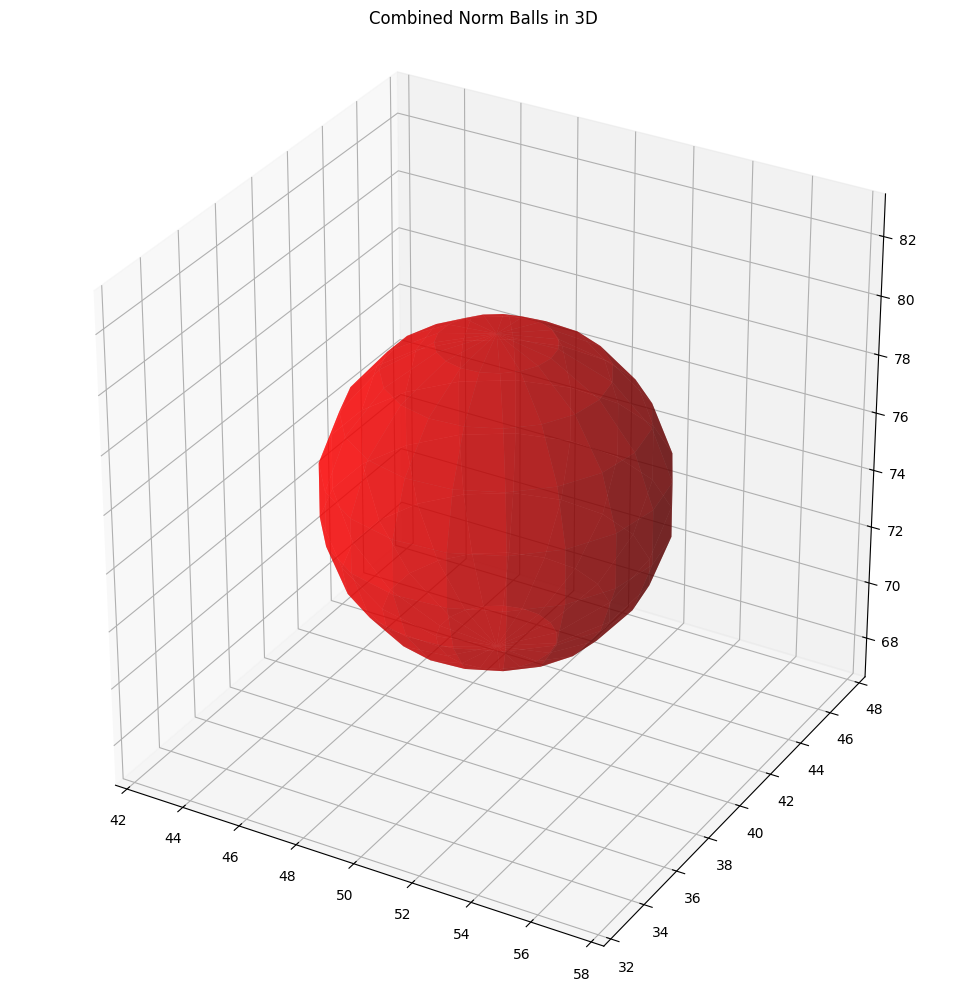

In [113]:
# store the radius of each ball for plotting:

import sys
sys.path.append("..")  # Adds the parent directory to the path

from norms.plotting_norms import plot_3d_norm_balls

# radius_dict = {'linf': 1, 'l1': 0.8, 'l2': 1.2}
# plot_3d_norm_balls((0, 0, 0), norm_types=('linf', 'l2'), radius_dict=radius_dict, same_figure=True)

radius_dict = {'linf': np.sqrt(m.obj()), 'l1': np.sqrt(m.obj()), 'l2': np.sqrt(m.obj())}

plot_3d_norm_balls(center = center, norm_types = ('l2',), radius_dict=radius_dict, same_figure=True)

### All together

Problem solved successfully.

Using infinity norm ball
Input 1: 58.13 (Center: 50)
Input 2: 48.13 (Center: 40)
Input 3: 66.87 (Center: 75)
Norm of input differences from center (infinity norm ball): 8.13
Output 1: 93.36 (Bounds: 70 - 95)
Output 2: 79.02 (Bounds: 70 - 95)

Power balance (difference between generation and load): -0.75 kW
The generation is exceeded by the load by 0.75 kW




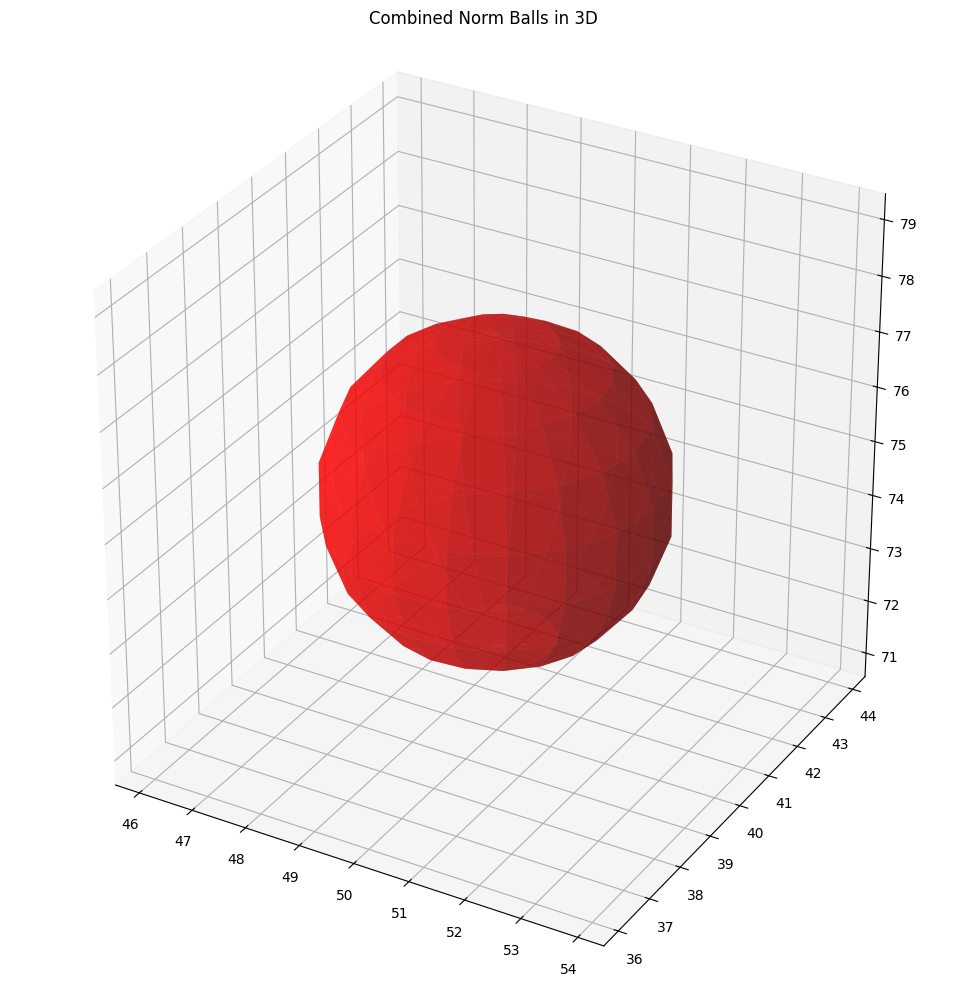

In [189]:
import numpy as np
import pyomo.environ as pyo
from omlt import OmltBlock
from omlt.neuralnet import FullSpaceNNFormulation
from omlt.io import write_onnx_model_with_bounds, load_onnx_neural_network_with_bounds
from norms.plotting_norms import plot_3d_norm_balls


import numpy as np

class DC_OPF:
    """
    A class for optimizing neural network constraints within a power system context,
    particularly focused on DC optimal power flow problems.
    """

    def __init__(self, onnx_file, center, nn_model=None, norm_type = 'infinity', epsilon_infinity=10, margin=1e-3):
        """
        Attributes:
        onnx_file (str): Path to the ONNX model file.

        nn_model: The neural network model object, default is None.

        epsilon_infinity (float): Radius for the infinity norm constraints around the center.
        center (np.array): Central point in the input space around which bounds are calculated.
        margin (float): Small margin used in constraints to ensure non-strict inequalities.

        input_bounds (dict): Calculated bounds for the input variables.
        network_definition: Loaded ONNX network definition.
        formulation: OMLT formulation created from the ONNX model.

        model: The Pyomo model object.
        norm_type (str): Type of norm used ('infinity', 'l1', or 'l2') for the optimization problem.
        """

        self.onnx_file = onnx_file
        self.nn_model = nn_model

        self.center = np.array(center)
        self.epsilon_infinity = epsilon_infinity
        self.margin = margin

        self.input_bounds = self._calculate_bounds()
        self.network_definition = None
        self.formulation = None

        self.model = None    
        self.norm_type = norm_type  # default norm type

    def _calculate_bounds(self):
        """Calculates the input bounds based on the center and epsilon_infinity."""
        lb = self.center - self.epsilon_infinity
        ub = self.center + self.epsilon_infinity
        return {i: (float(lb[i]), float(ub[i])) for i in range(len(self.center))}

    def load_onnx(self):
        """
        Loads the ONNX model and sets up the neural network formulation.

        This method writes the ONNX model with the specified input bounds, 
        loads the network definition, and creates the neural network formulation.
        """
        write_onnx_model_with_bounds(self.onnx_file, None, self.input_bounds)
        self.network_definition = load_onnx_neural_network_with_bounds(self.onnx_file)
        self.formulation = FullSpaceNNFormulation(self.network_definition)


    def declare_variables(self):
        """
        Declares the necessary variables and constraints in the Pyomo model.

        Sets up a concrete model with input and output variables, auxiliary variables based on the norm type,
        and constraints to link these variables with the neural network inputs and outputs.
        """
        m = pyo.ConcreteModel()
        m.nn = OmltBlock()
        m.nn.build_formulation(self.formulation)
        m.input = pyo.Var([0, 1, 2], domain=pyo.NonNegativeReals)  # Assuming inputs should be non-negative
        m.output = pyo.Var([0, 1], domain=pyo.Reals)

        # Auxiliary variable for different norms
        if self.norm_type == 'infinity':
            m.auxiliary = pyo.Var(domain=pyo.NonNegativeReals)
        elif self.norm_type == 'l1':
            m.auxiliary = pyo.Var([0, 1, 2], domain=pyo.NonNegativeReals)

        # Constraints to connect neural network inputs and outputs
        m.connect_inputs = pyo.ConstraintList()
        m.connect_outputs = pyo.ConstraintList()
        for i in range(3):  # For input connections
            m.connect_inputs.add(m.input[i] == m.nn.inputs[i])
        for j in range(2):  # For output connections
            m.connect_outputs.add(m.output[j] == m.nn.outputs[j])

        self.model = m


    def create_opt_problem(self, power_balance_constraint1=True, power_balance_constraint2=False,
                       generator1_upper_bound=False, generator1_lower_bound=False,
                       generator2_upper_bound=False, generator2_lower_bound=False):
        """
        Sets up the optimization problem with specified constraints.

        Args:
            power_balance_constraint1 (bool): Activates a constraint to enforce upper bound on power balance.
            power_balance_constraint2 (bool): Activates a constraint to enforce lower bound on power balance.
            generator1_upper_bound (bool): Activates the upper bound constraint for generator 1.
            generator1_lower_bound (bool): Activates the lower bound constraint for generator 1.
            generator2_upper_bound (bool): Activates the upper bound constraint for generator 2.
            generator2_lower_bound (bool): Activates the lower bound constraint for generator 2.
        """

        if sum([power_balance_constraint1, power_balance_constraint2, generator1_upper_bound, generator1_lower_bound, generator2_upper_bound, generator2_lower_bound]) > 1:
            power_balance_constraint1 = False
        
        assert sum([power_balance_constraint1, power_balance_constraint2, generator1_upper_bound, generator1_lower_bound, generator2_upper_bound, generator2_lower_bound]) == 1, "Only one of the constraints should be True"
        
        self.power_balance_constraint1 = power_balance_constraint1
        self.power_balance_constraint2 = power_balance_constraint2
        self.generator1_upper_bound = generator1_upper_bound
        self.generator1_lower_bound = generator1_lower_bound
        self.generator2_upper_bound = generator2_upper_bound
        self.generator2_lower_bound = generator2_lower_bound


        # Declare variables and constraints in the Pyomo model
        self.declare_variables()
        m = self.model
        input_neurons = 3  # Number of input neurons

        # Define power balance constraints if specified
        if self.power_balance_constraint1 or self.power_balance_constraint2:
            balance = m.output[0] + m.output[1] - sum(m.input[i] for i in range(input_neurons))
            d_highest = max(self.center)
            ub_power_balance = max(10**-2, 10**-2 * d_highest)
            lb_power_balance = -ub_power_balance
            if self.power_balance_constraint1:
                m.power_balance_constraint = pyo.Constraint(expr=(ub_power_balance - balance <= 0))
            if self.power_balance_constraint2:
                m.power_balance_constraint = pyo.Constraint(expr=(balance - lb_power_balance <= 0))

        # Define generator bounds constraints if specified
        for i in range(2):  # Assuming two outputs
            if i == 0 and (self.generator1_upper_bound or self.generator1_lower_bound):
                if self.generator1_upper_bound:
                    m.generator1_bound = pyo.Constraint(expr=(max_gen1 - m.output[i] + self.margin <= 0))
                if self.generator1_lower_bound:
                    m.generator1_bound = pyo.Constraint(expr=(m.output[i] - min_gen1 + self.margin <= 0))
            elif i == 1 and (self.generator2_upper_bound or self.generator2_lower_bound):
                if self.generator2_upper_bound:
                    m.generator2_bound = pyo.Constraint(expr=(max_gen2 - m.output[i] + self.margin <= 0))
                if self.generator2_lower_bound:
                    m.generator2_bound = pyo.Constraint(expr=(m.output[i] - min_gen2 + self.margin <= 0))

        # Define norm constraints and objective function
        self.define_norm_constraints(input_neurons, m)

    def define_norm_constraints(self, input_neurons, m):
        """
        Define norm constraints based on the selected norm type and set up the objective function.

        Args:
            input_neurons (int): Number of input neurons.
            m (pyo.ConcreteModel): The Pyomo model.
        """
        if self.norm_type == 'l1':
            m.l1_constraints = pyo.ConstraintList()
            for i in range(input_neurons):
                m.l1_constraints.add(m.input[i] - self.center[i] <= m.auxiliary[i])
                m.l1_constraints.add(-m.auxiliary[i] <= m.input[i] - self.center[i])
            m.obj = pyo.Objective(expr=sum(m.auxiliary[i] for i in range(input_neurons)), sense=pyo.minimize)
        elif self.norm_type == 'l2':
            m.obj = pyo.Objective(expr=sum((m.input[i] - self.center[i])**2 for i in range(input_neurons)), sense=pyo.minimize)
        else:  # 'infinity' norm by default
            m.l1_constraints = pyo.ConstraintList()
            for i in range(input_neurons):
                m.l1_constraints.add(m.input[i] - self.center[i] <= m.auxiliary)
                m.l1_constraints.add(-m.auxiliary <= m.input[i] - self.center[i])
            m.obj = pyo.Objective(expr=m.auxiliary, sense=pyo.minimize)


    def solve_opt_problem(self, solver = None):
        """
        Solves the optimization problem using the CBC solver and returns the model's inputs and outputs.

        Prints the outcome of the optimization process. If the solver reaches an optimal solution,
        it reports success; otherwise, it indicates failure.

        Returns:
            list: Values of the input variables after solving the optimization problem.
            list: Values of the output variables after solving the optimization problem.
        """

        # assert that in l2 case, solver is bonmin
        if solver is None:
            if self.norm_type == 'l2':
                solver = 'bonmin'
            else:
                solver = 'cbc'

        if self.norm_type == 'l2':
            assert solver == 'bonmin', "Solver must be 'bonmin' for l2 norm."

        solver_status = pyo.SolverFactory(solver).solve(self.model, tee=False)  # tee=False suppresses solver output

        # Initialize lists to store input and output values
        inputs = []
        outputs = []

        # Check if the solver found an optimal solution
        if solver_status.solver.termination_condition == pyo.TerminationCondition.optimal:
            print("Problem solved successfully.")
            # Retrieve and store input values
            inputs = [self.model.input[i].value for i in self.model.input]
            # Retrieve and store output values
            outputs = [self.model.output[i].value for i in self.model.output]
        else:
            print("The solver failed to solve the problem.")

        return inputs, outputs


    def display_results(self, inputs=None, outputs=None):
        """
        Displays the results of the optimization process, allowing for custom or default input and output values,
        including the calculated norm of the inputs relative to the center.

        Parameters:
        - inputs (list or None): Custom list of input values to display. If None, uses model's inputs.
        - outputs (list or None): Custom list of output values to display. If None, uses model's outputs.

        This method prints:
        - The type of norm used in the optimization.
        - The values of the input and output variables, including how they compare to predefined bounds.
        - The norm of the input differences from the center.
        - The power balance and how it relates to generation and load.
        - The value of the primary property being enforced by constraints.
        - The objective function value.
        """
        # Determine the norm type used for easier reference in the output
        norm_type = "infinity norm ball" if self.norm_type == 'infinity' else \
                    "L1 norm ball" if self.norm_type == 'l1' else "L2 norm ball"
        print(f"\nUsing {norm_type}")

        # Use model's inputs and outputs if none are provided
        if inputs is None:
            inputs = [self.model.input[i].value for i in range(len(self.model.input))]
        if outputs is None:
            outputs = [self.model.output[i].value for i in range(len(self.model.output))]

        # Display input variable values and their respective centers
        for i, input_value in enumerate(inputs):
            print(f"Input {i + 1}: {input_value:.2f} (Center: {self.center[i]})")

        # Calculate and display the norm of the input differences from the center
        norm_value = self.norm_calculator(inputs)
        print(f"Norm of input differences from center ({norm_type}): {norm_value:.2f}")

        # Define bounds for generators
        max_gen = [max_gen1, max_gen2]  # Maximum generator output values
        min_gen = [min_gen1, min_gen2]  # Minimum generator output values

        # Display output variable values and their bounds
        for i, output_value in enumerate(outputs):
            print(f"Output {i + 1}: {output_value:.2f} (Bounds: {min_gen[i]} - {max_gen[i]})")

        # Calculate and display the power balance difference if using model's data
        difference = sum(outputs) - sum(inputs)
        balance_msg = "exceeds the load by" if difference > 0 else "is exceeded by the load by"
        print(f"\nPower balance (difference between generation and load): {difference:.2f} kW")
        print(f"The generation {balance_msg} {abs(difference):.2f} kW")

        print("\n")



    def norm_calculator(self, input_vector, center=None, norm_type=None):
        """
        Calculates the norm of the difference between a given input vector and the center.

        Parameters:
        - input_vector (list or np.array): The input vector for which the norm needs to be calculated.
        - center (list or np.array, optional): The center vector to calculate the norm against. Defaults to self.center.
        - norm_type (str, optional): The type of norm to calculate ('l1', 'l2', or 'infinity'). Defaults to self.norm_type.

        Returns:
        - float: The calculated norm.
        """
        # Default to class attributes if not specified
        if center is None:
            center = self.center
        if norm_type is None:
            norm_type = self.norm_type

        # Calculate the difference vector
        diff_vector = np.array(input_vector) - np.array(center)

        # Calculate the specified norm
        if norm_type == 'l1':
            norm_value = np.sum(np.abs(diff_vector))
        elif norm_type == 'l2':
            norm_value = np.sqrt(np.sum(np.square(diff_vector)))
        elif norm_type == 'infinity':
            norm_value = np.max(np.abs(diff_vector))
        else:
            raise ValueError("Invalid norm type specified. Choose 'l1', 'l2', or 'infinity'.")

        return norm_value


    def maximum_feasible_ball(self):
        """
        Determines the configuration that results in the smallest feasible region by varying constraint settings.

        Iterates over a predefined set of configurations, each differing in the constraints applied,
        to find which configuration yields the smallest objective value, indicating the tightest feasible region.

        Returns:
            float: The size of the smallest feasible region found.
            dict: The configuration that resulted in the smallest feasible region.
        """
        smallest_region = float('inf')
        best_config = None
        best_input = None
        best_output = None

        configurations = [
            {'power_balance_constraint1': True, 'power_balance_constraint2': False},
            {'power_balance_constraint2': True},
            {'generator1_upper_bound': True},
            {'generator1_lower_bound': True},
            {'generator2_upper_bound': True},
            {'generator2_lower_bound': True},
        ]

        for config in configurations:
            # Create and solve the optimization problem with the current configuration
            self.create_opt_problem(**config)
            input, output = self.solve_opt_problem()
            self.display_results()
            # Fetch the objective function value which quantifies the size of the feasible region
            region_size = self.model.obj() if self.model.obj.expr() is not None else float('inf')

            # Check if the current configuration results in a smaller feasible region
            if region_size < smallest_region:
                smallest_region = region_size
                best_config = config
                best_input = input
                best_output = output


        print(f"Smallest feasible region size: {smallest_region}")
        print(f"Best configuration: {best_config}")

        self.display_results(best_input, best_output)
        return smallest_region, best_config

    def plot_norm_balls(self):
        """
        Plots 3D norm balls based on the objective function values from the optimization model.

        Uses different norms as specified in the radius dictionary. The radii are derived from the square root
        of the objective function value, which should represent the size of the feasible region in some way.
        """

        # Check if the optimization problem has been solved and the objective value is available
        if hasattr(self.model, 'obj') and self.model.obj() is not None:
            # Prepare radius dictionary
            radius_dict = {
                'infinity': np.sqrt(self.model.obj()),
                'l1': np.sqrt(self.model.obj()),
                'l2': np.sqrt(self.model.obj())
            }

            # Call the external plotting function
            plot_3d_norm_balls(center=self.center, norm_types=('l2',), radius_dict=radius_dict, same_figure=True)
        else:
            print("Optimization problem must be solved first, and objective must be set.")

    



# Example usage
onnx_file = f.name
center = [50, 40, 75]
epsilon_infinity = 150
margin = 1e-3
norm_type = 'infinity'

dc_opf = DC_OPF(onnx_file = onnx_file, center = center, epsilon_infinity = epsilon_infinity, margin = margin, norm_type = norm_type)
dc_opf.load_onnx()
dc_opf.create_opt_problem(power_balance_constraint2=True)
dc_opf.solve_opt_problem()
dc_opf.display_results()
dc_opf.plot_norm_balls()
# smallest_region, best_config = dc_opf.maximum_feasible_ball()
